In [1]:
from __future__ import print_function
import PIL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

from mpl_toolkits import mplot3d
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
import os
from tqdm.notebook import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import stats, interpolate

from astroML import stats as astroMLstatsπ
from astropy.visualization import hist
from tqdm.notebook import tqdm
import random
import seaborn as sns

from sklearn import datasets, preprocessing
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

import emcee
import corner

# Noisy detector

We want to reconstruct the principal components of a signal from a noisy detector. Let's try with different decomposition analysis

## PCA

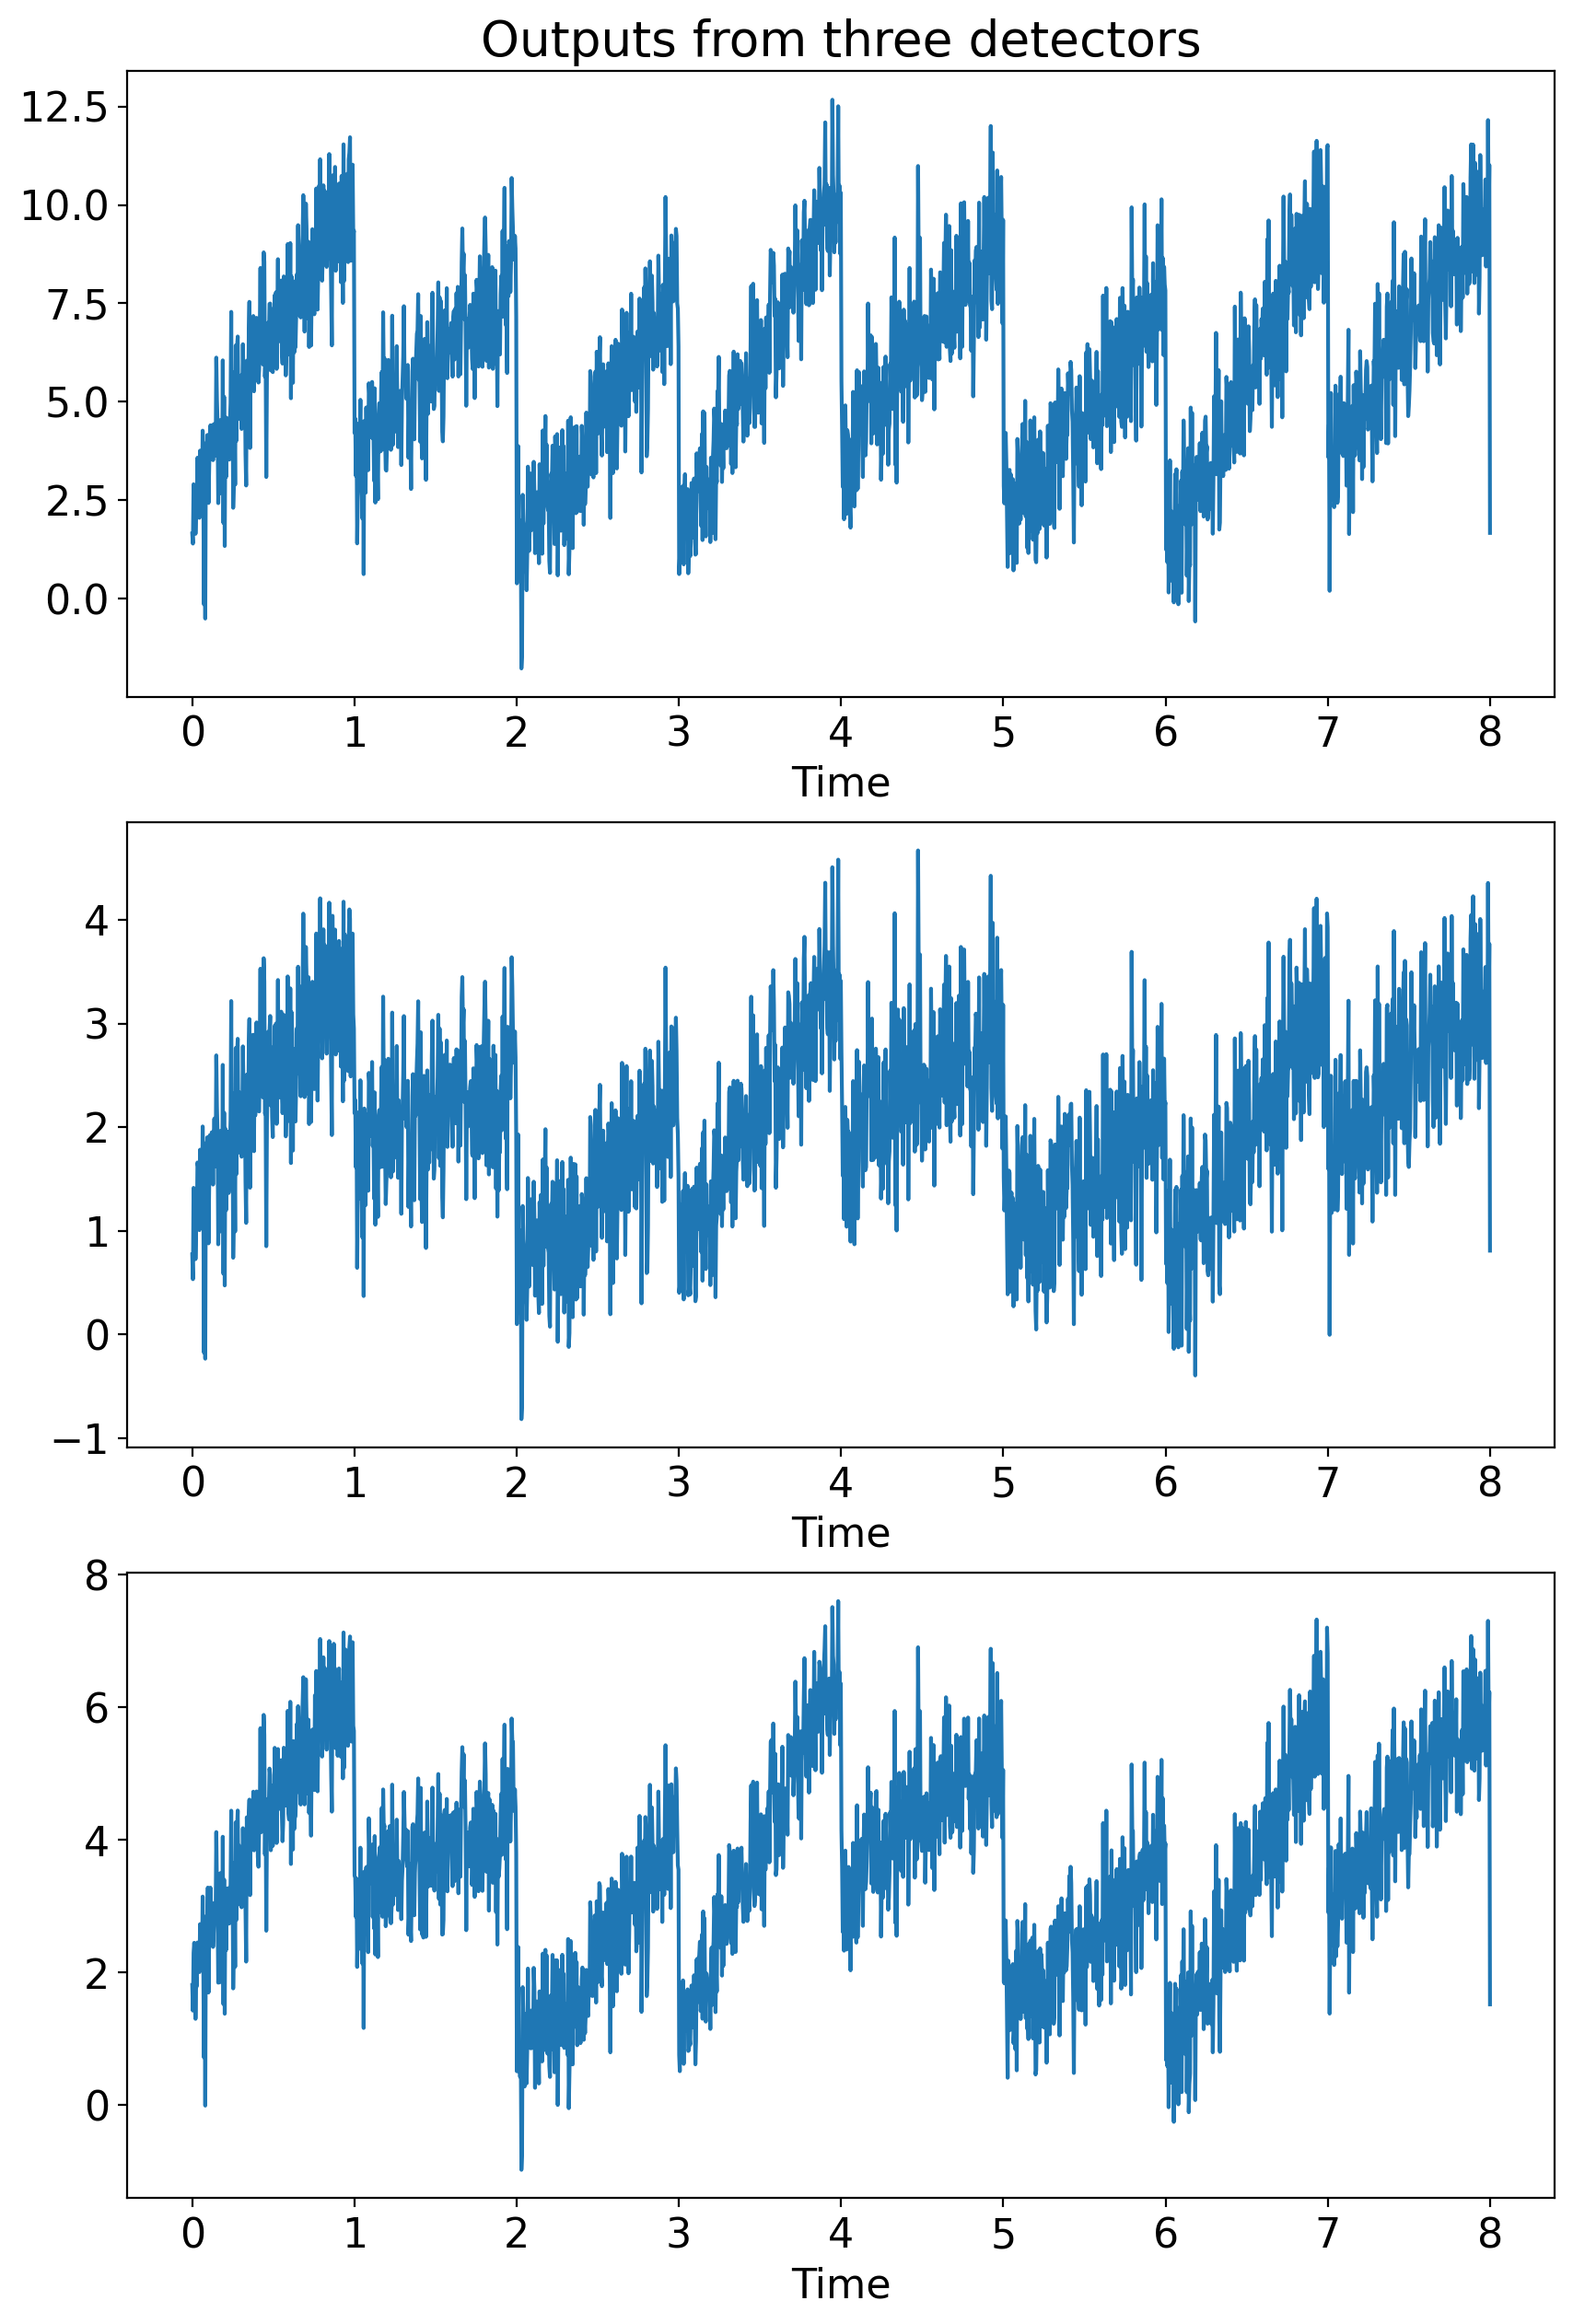

In [2]:
data=np.load('./noisydetector.npy')

time = np.linspace(0, 8, data.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,data.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');

In [3]:
n_components = 3
pca = PCA(n_components=n_components) # n_components can be optionally set
pca.fit(data)
eigenvalues = pca.transform(data) # compute the subspace projection of X, 4 eigenvalues for each of the 100 samples
mean = pca.mean_ # length 10 mean of the data
eigenvectors = pca.components_ # 4x10 matrix of components, multiply each by respective eigenvalue to reconstruct
evals = pca.explained_variance_ratio_ 

# Reconstruction of object1
# Xreconstruct[0] = mean + eigenvectors*eigenvalues[0]

print(eigenvalues.shape)
print(eigenvectors.shape)

(2000, 3)
(3, 3)


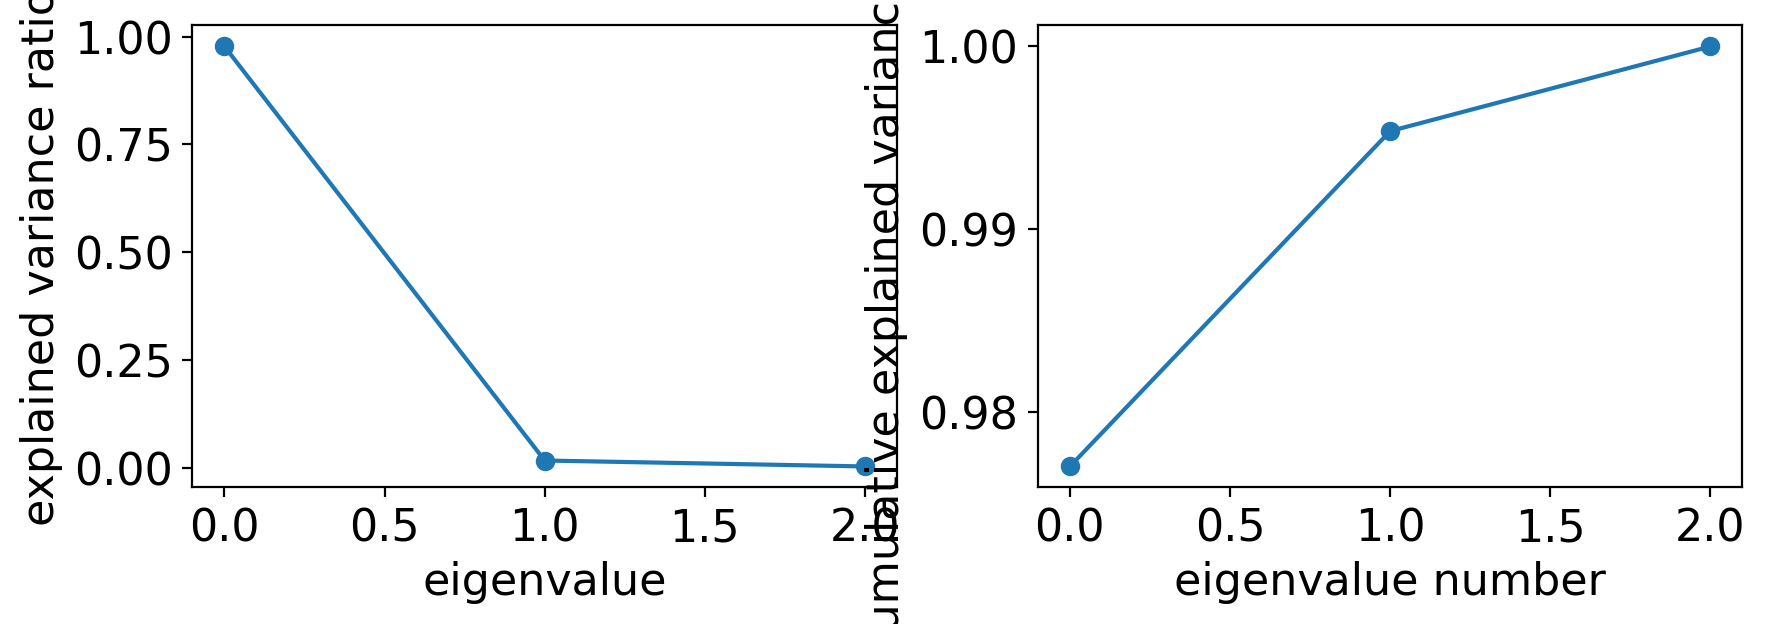

In [4]:
fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(121)

ax.plot(np.arange(n_components), evals)
ax.scatter(np.arange(n_components), evals)

ax.set_xlabel("eigenvalue")
ax.set_ylabel("explained variance ratio")

ax = fig.add_subplot(122)

ax.plot(np.arange(n_components), evals.cumsum())
ax.scatter(np.arange(n_components), evals.cumsum())

ax.set_xlabel("eigenvalue number")
ax.set_ylabel("cumulative explained variance ratio")

plt.show()

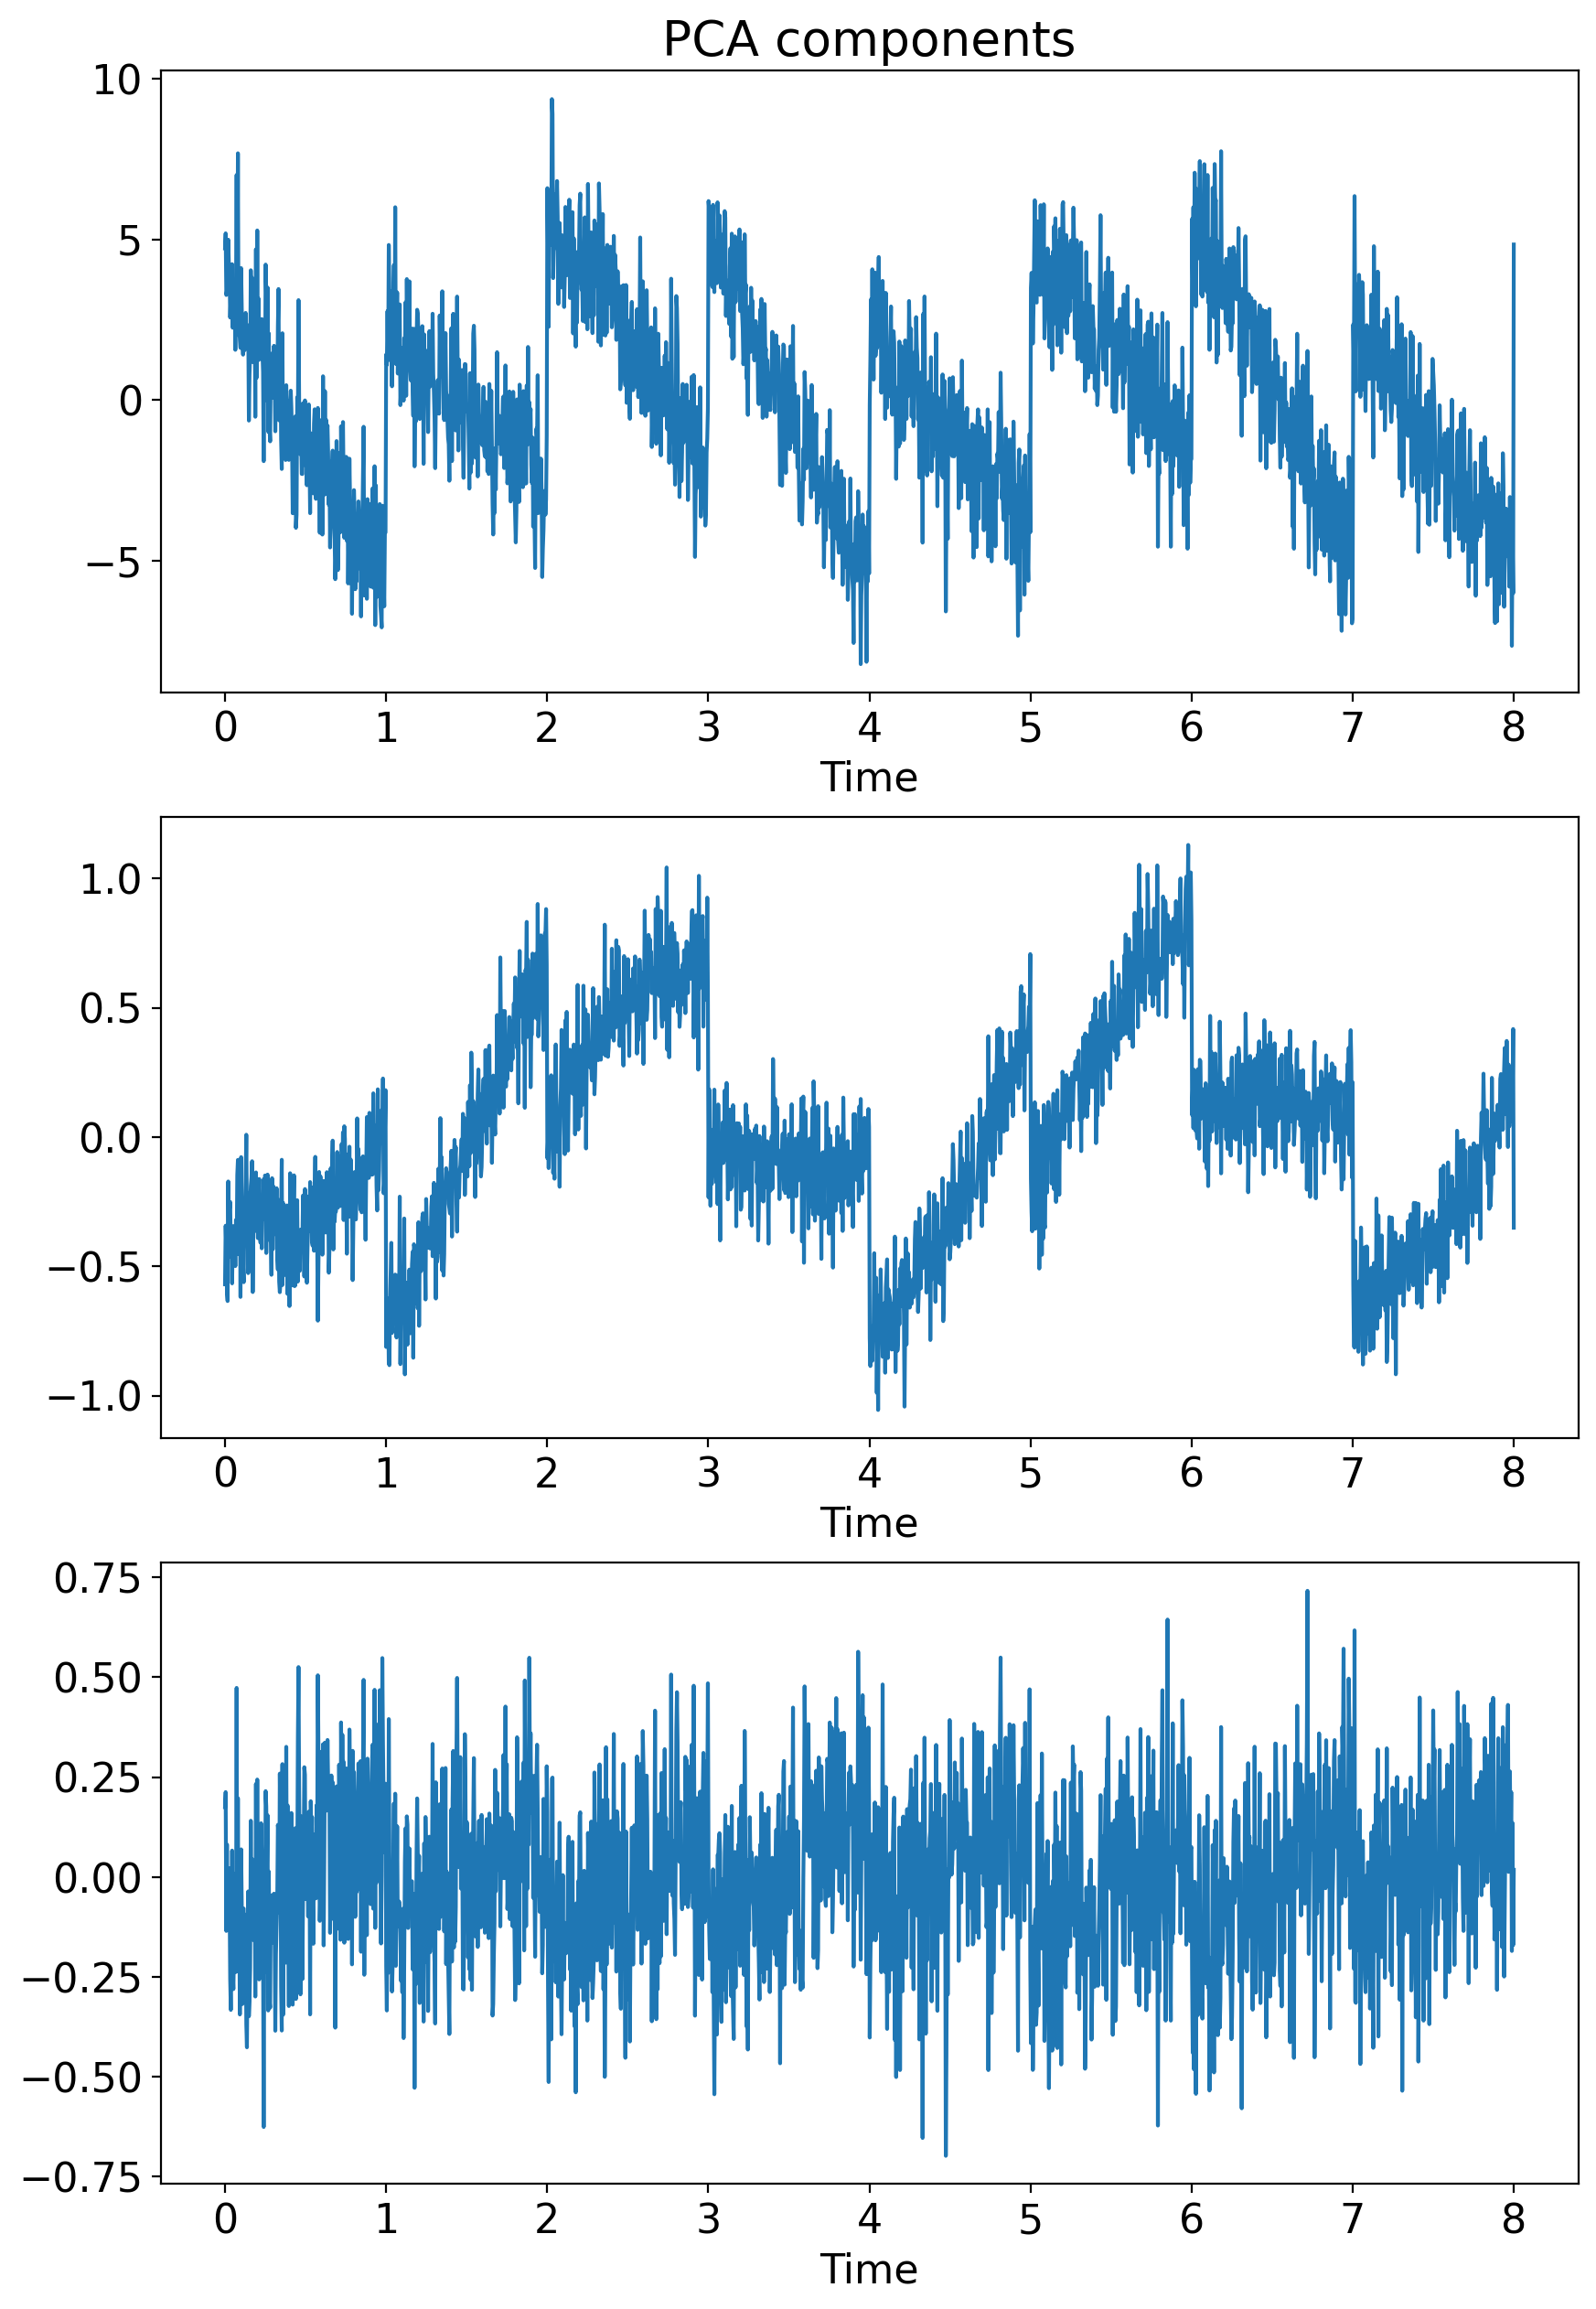

In [5]:
fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,eigenvalues.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('PCA components');

Ok... but these three does not look like true components, they are somewhat mixed

## ICA

The decomposition is really strong and valid! It decompose the data in **independent** components, which is amazing!

In [6]:
ica = FastICA(n_components=n_components) # Now reproject to 3-D
ica.fit(data)

proj = ica.transform(data) 
comp = ica.components_ 

/home/olga/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


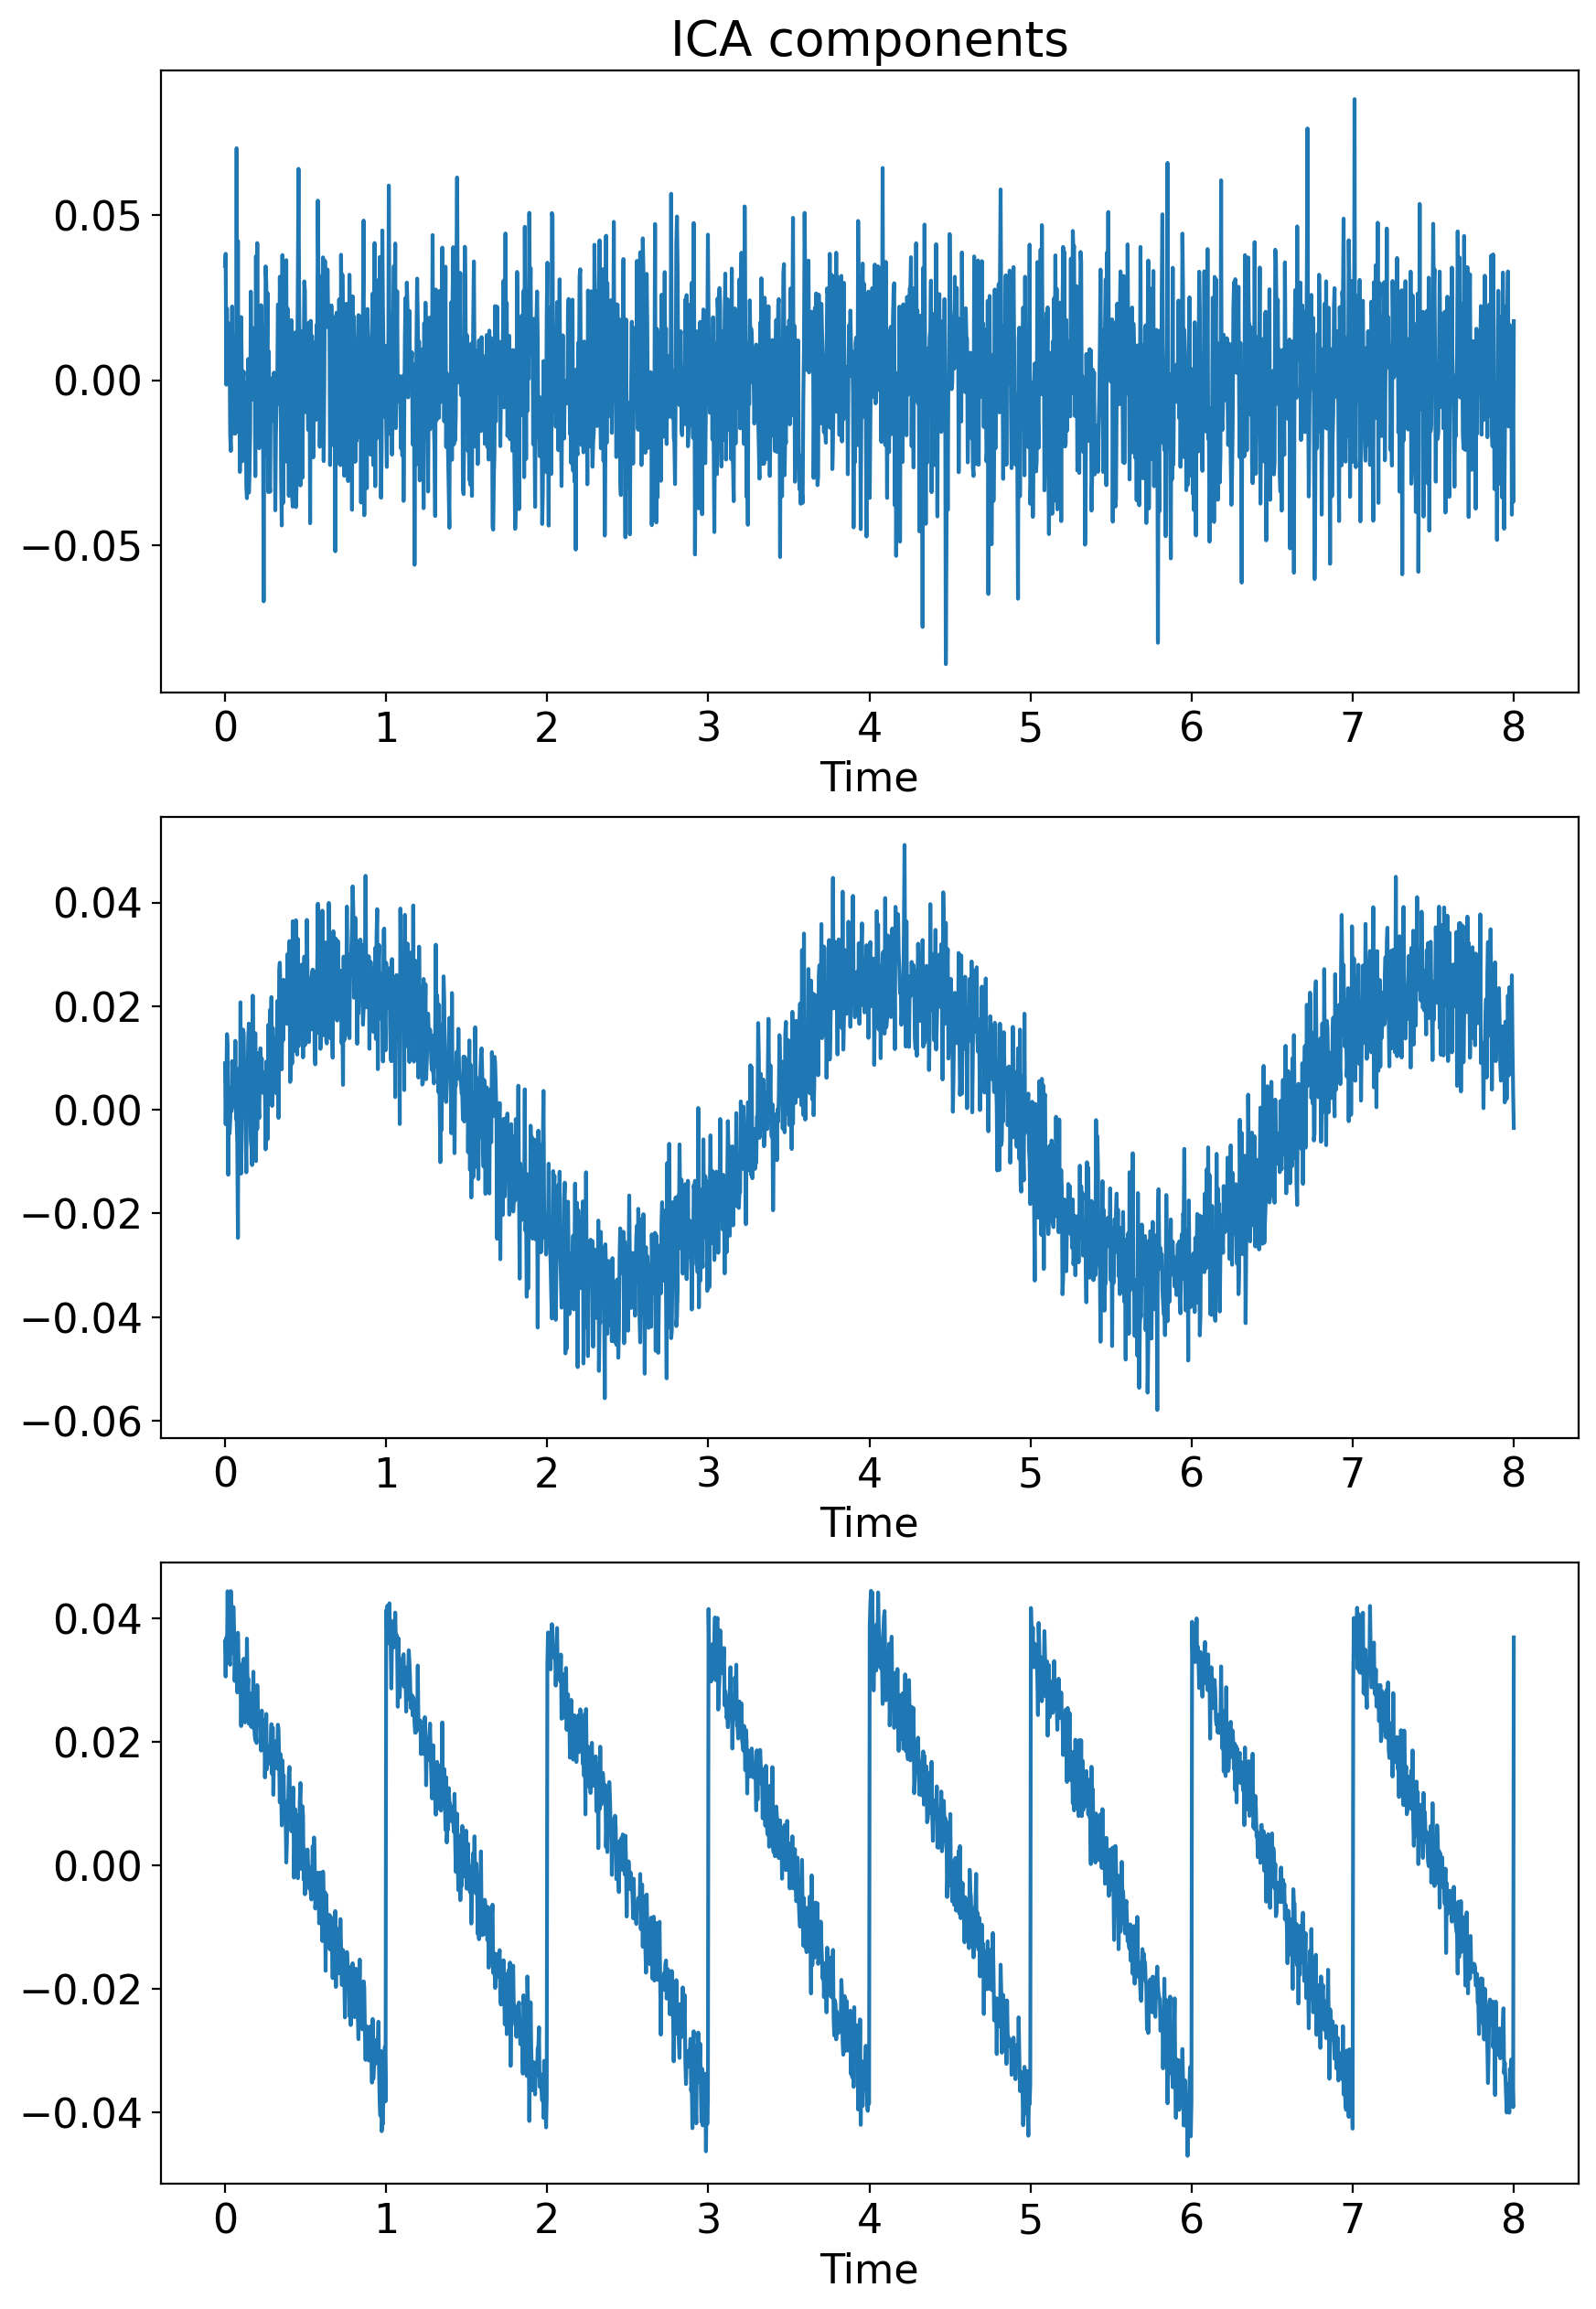

In [7]:
fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,proj.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('ICA components');

The third one really looks like a sinusoidal $\longrightarrow$ from that we can extract the period!

$\Longrightarrow$ try with MCMC

### MCMC for period $\omega$

Hypotesys:

$$y = Asin(\omega x + \phi)$$

--------

From MCMC with very strict prior, because otherwise the chain gets stuck, the result is $\omega = 1.86^{+0.7}_{-0.6} s^{-1} \longrightarrow$ which is very close to the "real" one of $\omega_{real} = \frac{2\pi}{3.3} = 1.9 s^{-1}$

In [8]:
#define the model
def sinusoidal(x, a, omega, phi):
    return a*np.sin(omega*x + phi)

#define the loglikelihood
def like(prob, time, sign, err_sign):
    a, omega, phi = prob
    return np.prod(np.exp(-1/2*(sign-sinusoidal(sign, a, omega, phi)/err_sign)**2))

#define the prior
def prior(prob):
    a, omega, phi = prob
    if a_guess - 0.03 < a < a_guess + 0.015 and omega_guess - 0.1 < omega < omega_guess + 0.1 and 0 < phi < 2*np.pi:
        return 1
    return 0

#define posterior
def logposterior(prob, time, signal, err_sign):
    return np.log(like(prob, time, signal, err_sign)*prior(prob))

In [9]:
sigma = 0.01
signal = proj[:,1].T
signal

array([ 0.00894673, -0.00279615,  0.00475148, ...,  0.0123884 ,
        0.00323552, -0.00350588])

In [12]:
mean = np.mean(signal)
max_s1 = np.max(signal[:1000])
max_s2 = np.max(signal[1000:])
a_guess = max_s1 - mean
period = float((time[signal == max_s2]) - (time[signal == max_s1]))
omega_guess = 2*np.pi/period 
phi_guess = 2*np.pi*1
print(a_guess, omega_guess, phi_guess)

0.04514597805431887 1.878003503147726 6.283185307179586


In [13]:
xgrid=np.linspace(0,8,3000)

plt.errorbar(time, signal, yerr=sigma, fmt="o", ms=6, mec="gray", ecolor='gray', mfc='turquoise',
             elinewidth=0.8, label='data', zorder=0)
plt.scatter(time,signal,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=1)
plt.axvline(time[signal == max_s1], color='k', linestyle='dashed')
plt.axvline(time[signal == max_s2], color='k', linestyle='dashed')
plt.axhline(mean, color='k', linestyle='dashed')
plt.plot(xgrid,  sinusoidal(xgrid, a_guess, omega_guess, phi_guess), 'r')
plt.xlabel("time")
plt.show()

#### run mcmc

In [14]:
ndim = 3  # number of parameters in the model
nwalkers = 20 # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))*1e-2+np.array([a_guess, omega_guess, phi_guess])

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=[time, signal, sigma])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
flat_trace = emcee_trace.flatten()

print("done")
print(starting_guesses)

/tmp/ipykernel_8315/4042991253.py:19: RuntimeWarning: divide by zero encountered in log
  return np.log(like(prob, time, signal, err_sign)*prior(prob))
/home/olga/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


done
[[0.05063411 1.8851554  6.28921294]
 [0.05059481 1.88224005 6.28964425]
 [0.04952185 1.88692123 6.29282193]
 [0.04898039 1.88592075 6.28847426]
 [0.05082642 1.88725947 6.28389567]
 [0.04601727 1.87820569 6.29151151]
 [0.05292755 1.88670362 6.29297149]
 [0.05313756 1.8826183  6.2909906 ]
 [0.04632872 1.88440271 6.28461884]
 [0.05459267 1.88322199 6.28733193]
 [0.04779153 1.88574584 6.28774681]
 [0.05083032 1.8781914  6.28936166]
 [0.05126694 1.88417284 6.29262279]
 [0.05196418 1.88159858 6.28755563]
 [0.05212229 1.87860576 6.28985297]
 [0.05185236 1.88010733 6.28447457]
 [0.04830026 1.88164061 6.28888727]
 [0.04953199 1.88788724 6.28420576]
 [0.04723475 1.8796166  6.28971639]
 [0.04767889 1.88266661 6.28562956]]


In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[44.76948691 64.34867658 60.20382845]


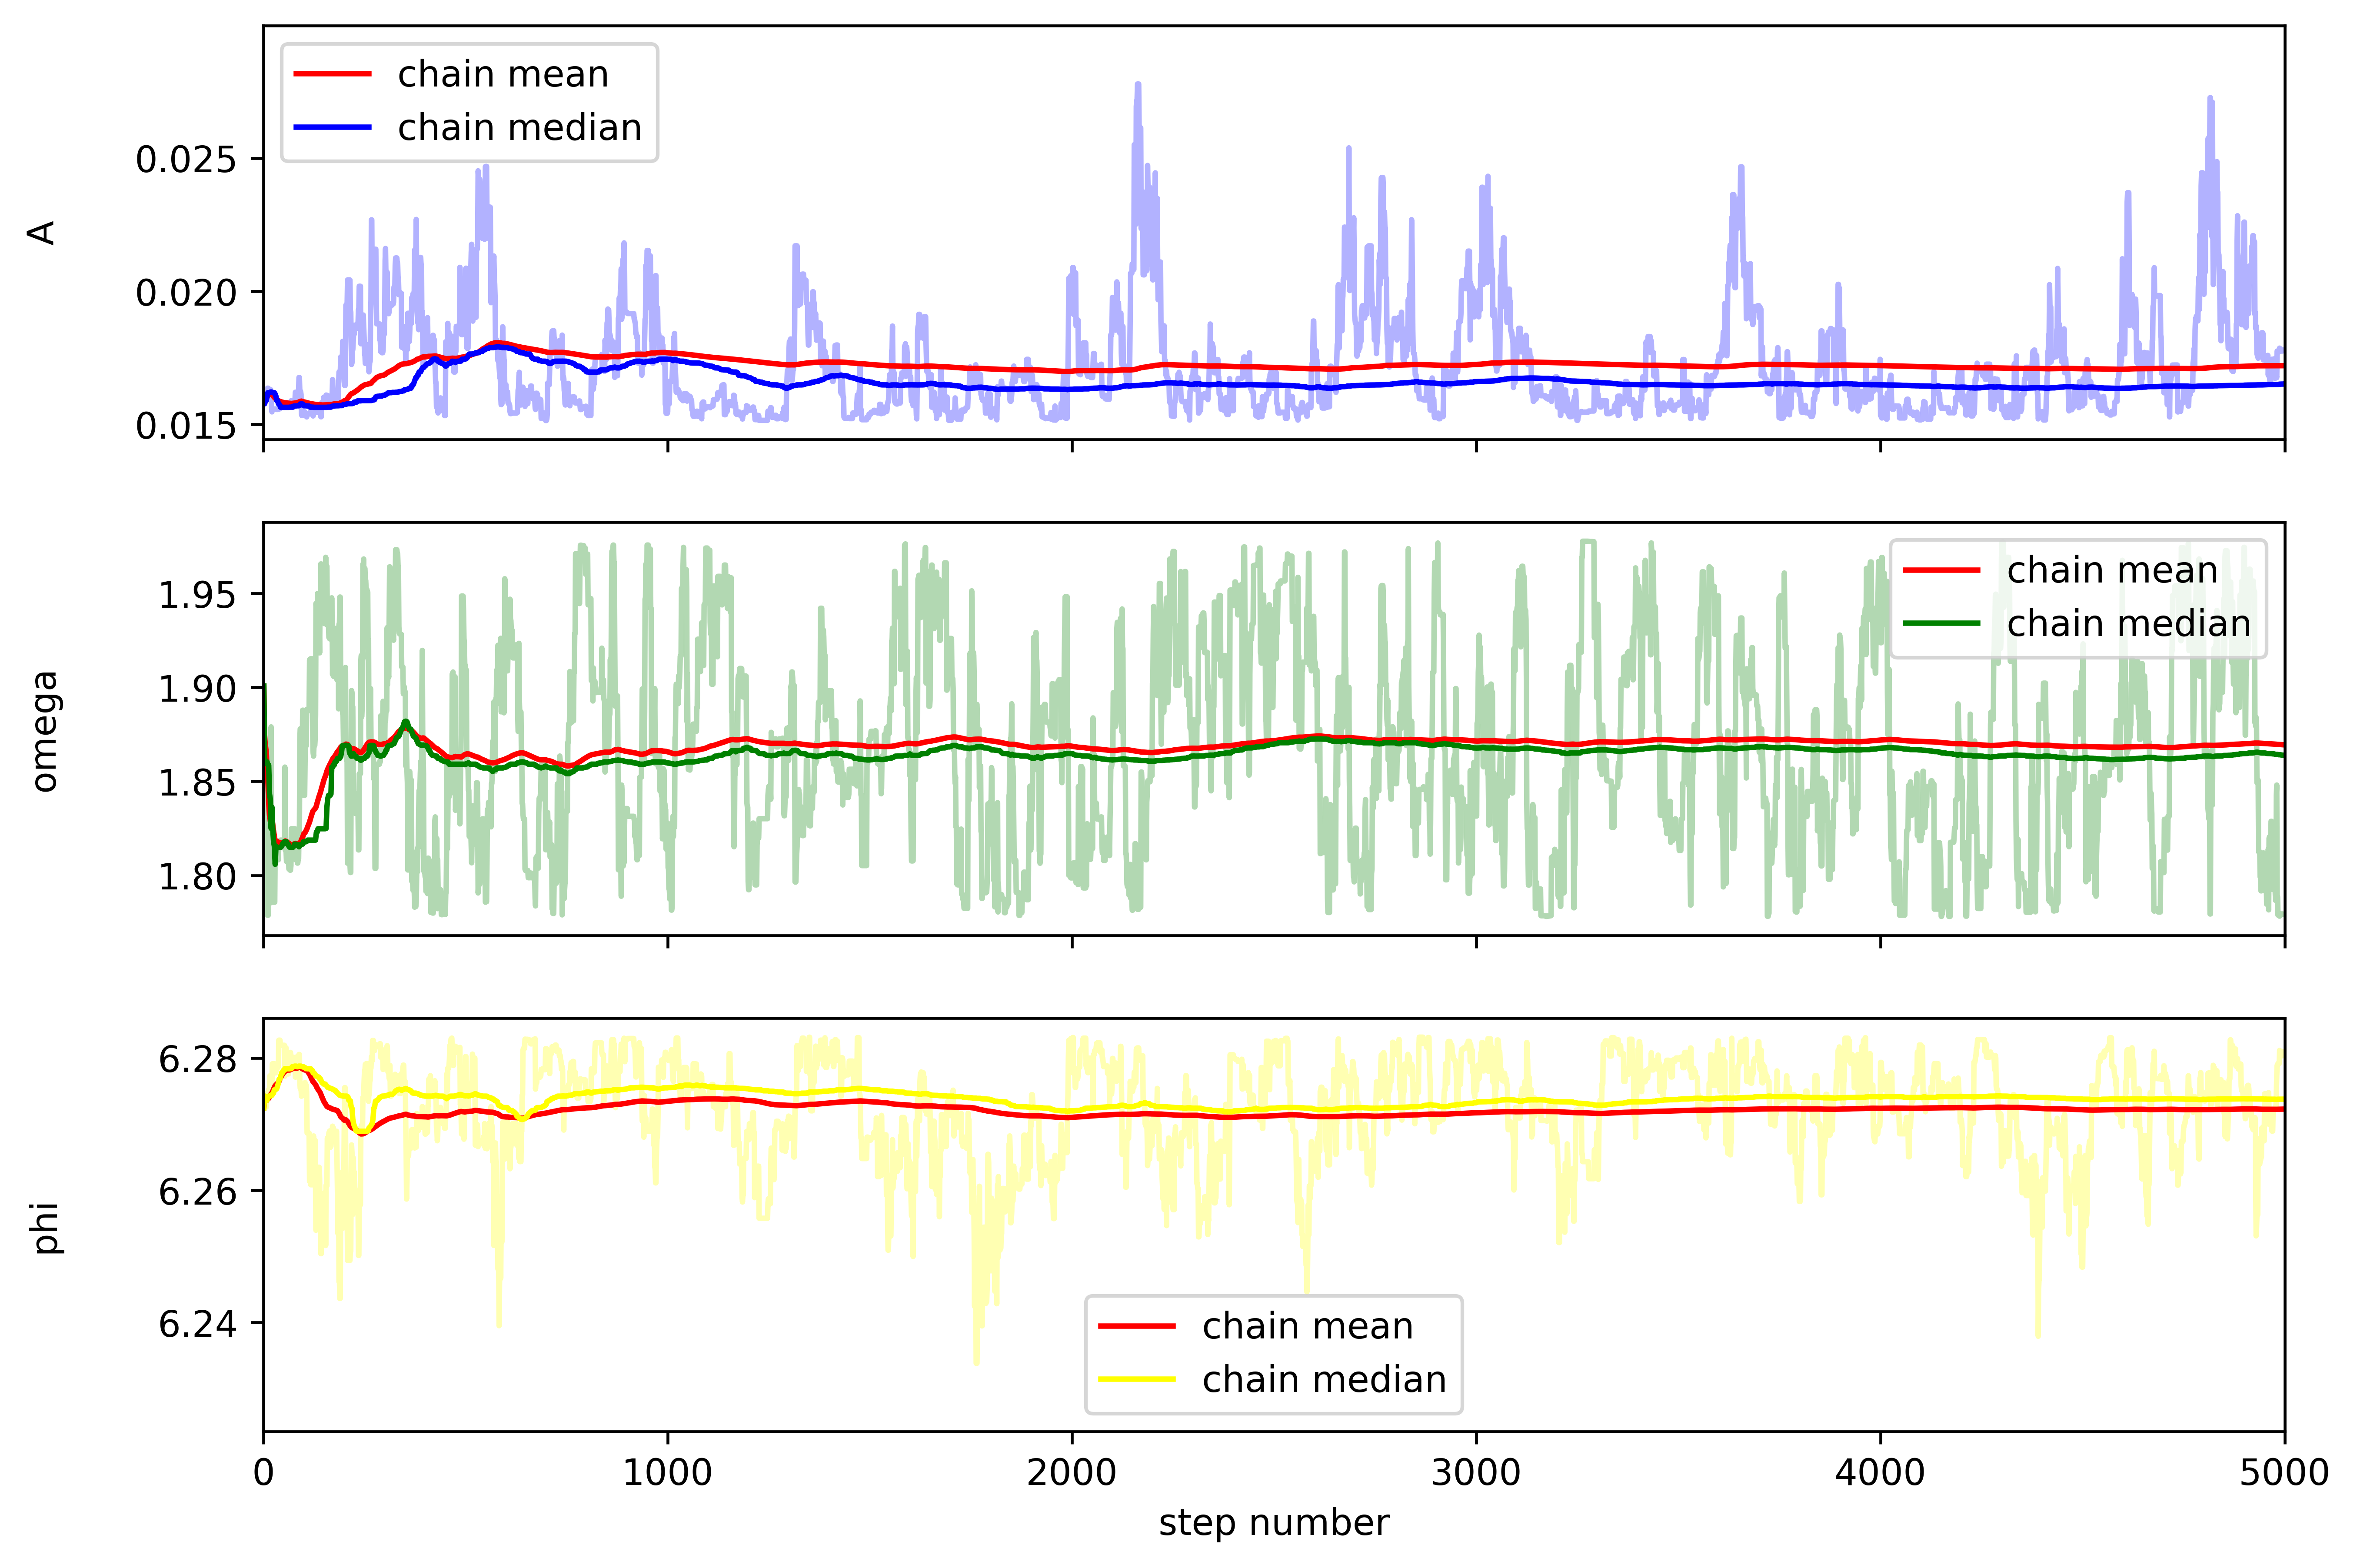

In [16]:
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 10

#plot 
xgrid1 = np.linspace(1, nsteps, nsteps)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
colors = ["blue", "green", "yellow"]
labels = ["A", "omega", "phi"]
meanC = []
median = []

for i in range(ndim):
                
    # plot running mean: 
    meanC_i = [np.mean(emcee_trace[:int(N),i]) for N in xgrid1]
    medianC_i = [np.median(emcee_trace[:int(N),i]) for N in xgrid1]
    meanC.append(meanC_i[nsteps-1])
    median.append(medianC_i[nsteps-1])
    
    ax = axes[i]
    ax.plot(emcee_trace[:,i], color=colors[i], alpha=0.3)
    ax.plot(xgrid1, meanC_i, c='red', label='chain mean')
    ax.plot(xgrid1, medianC_i, c=colors[i], label='chain median') 
    #ax.plot(xgrid, 0*xgrid + np.mean(data), c='yellow',label='data mean')
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.legend(fontsize=10)

axes[-1].set_xlabel("step number");

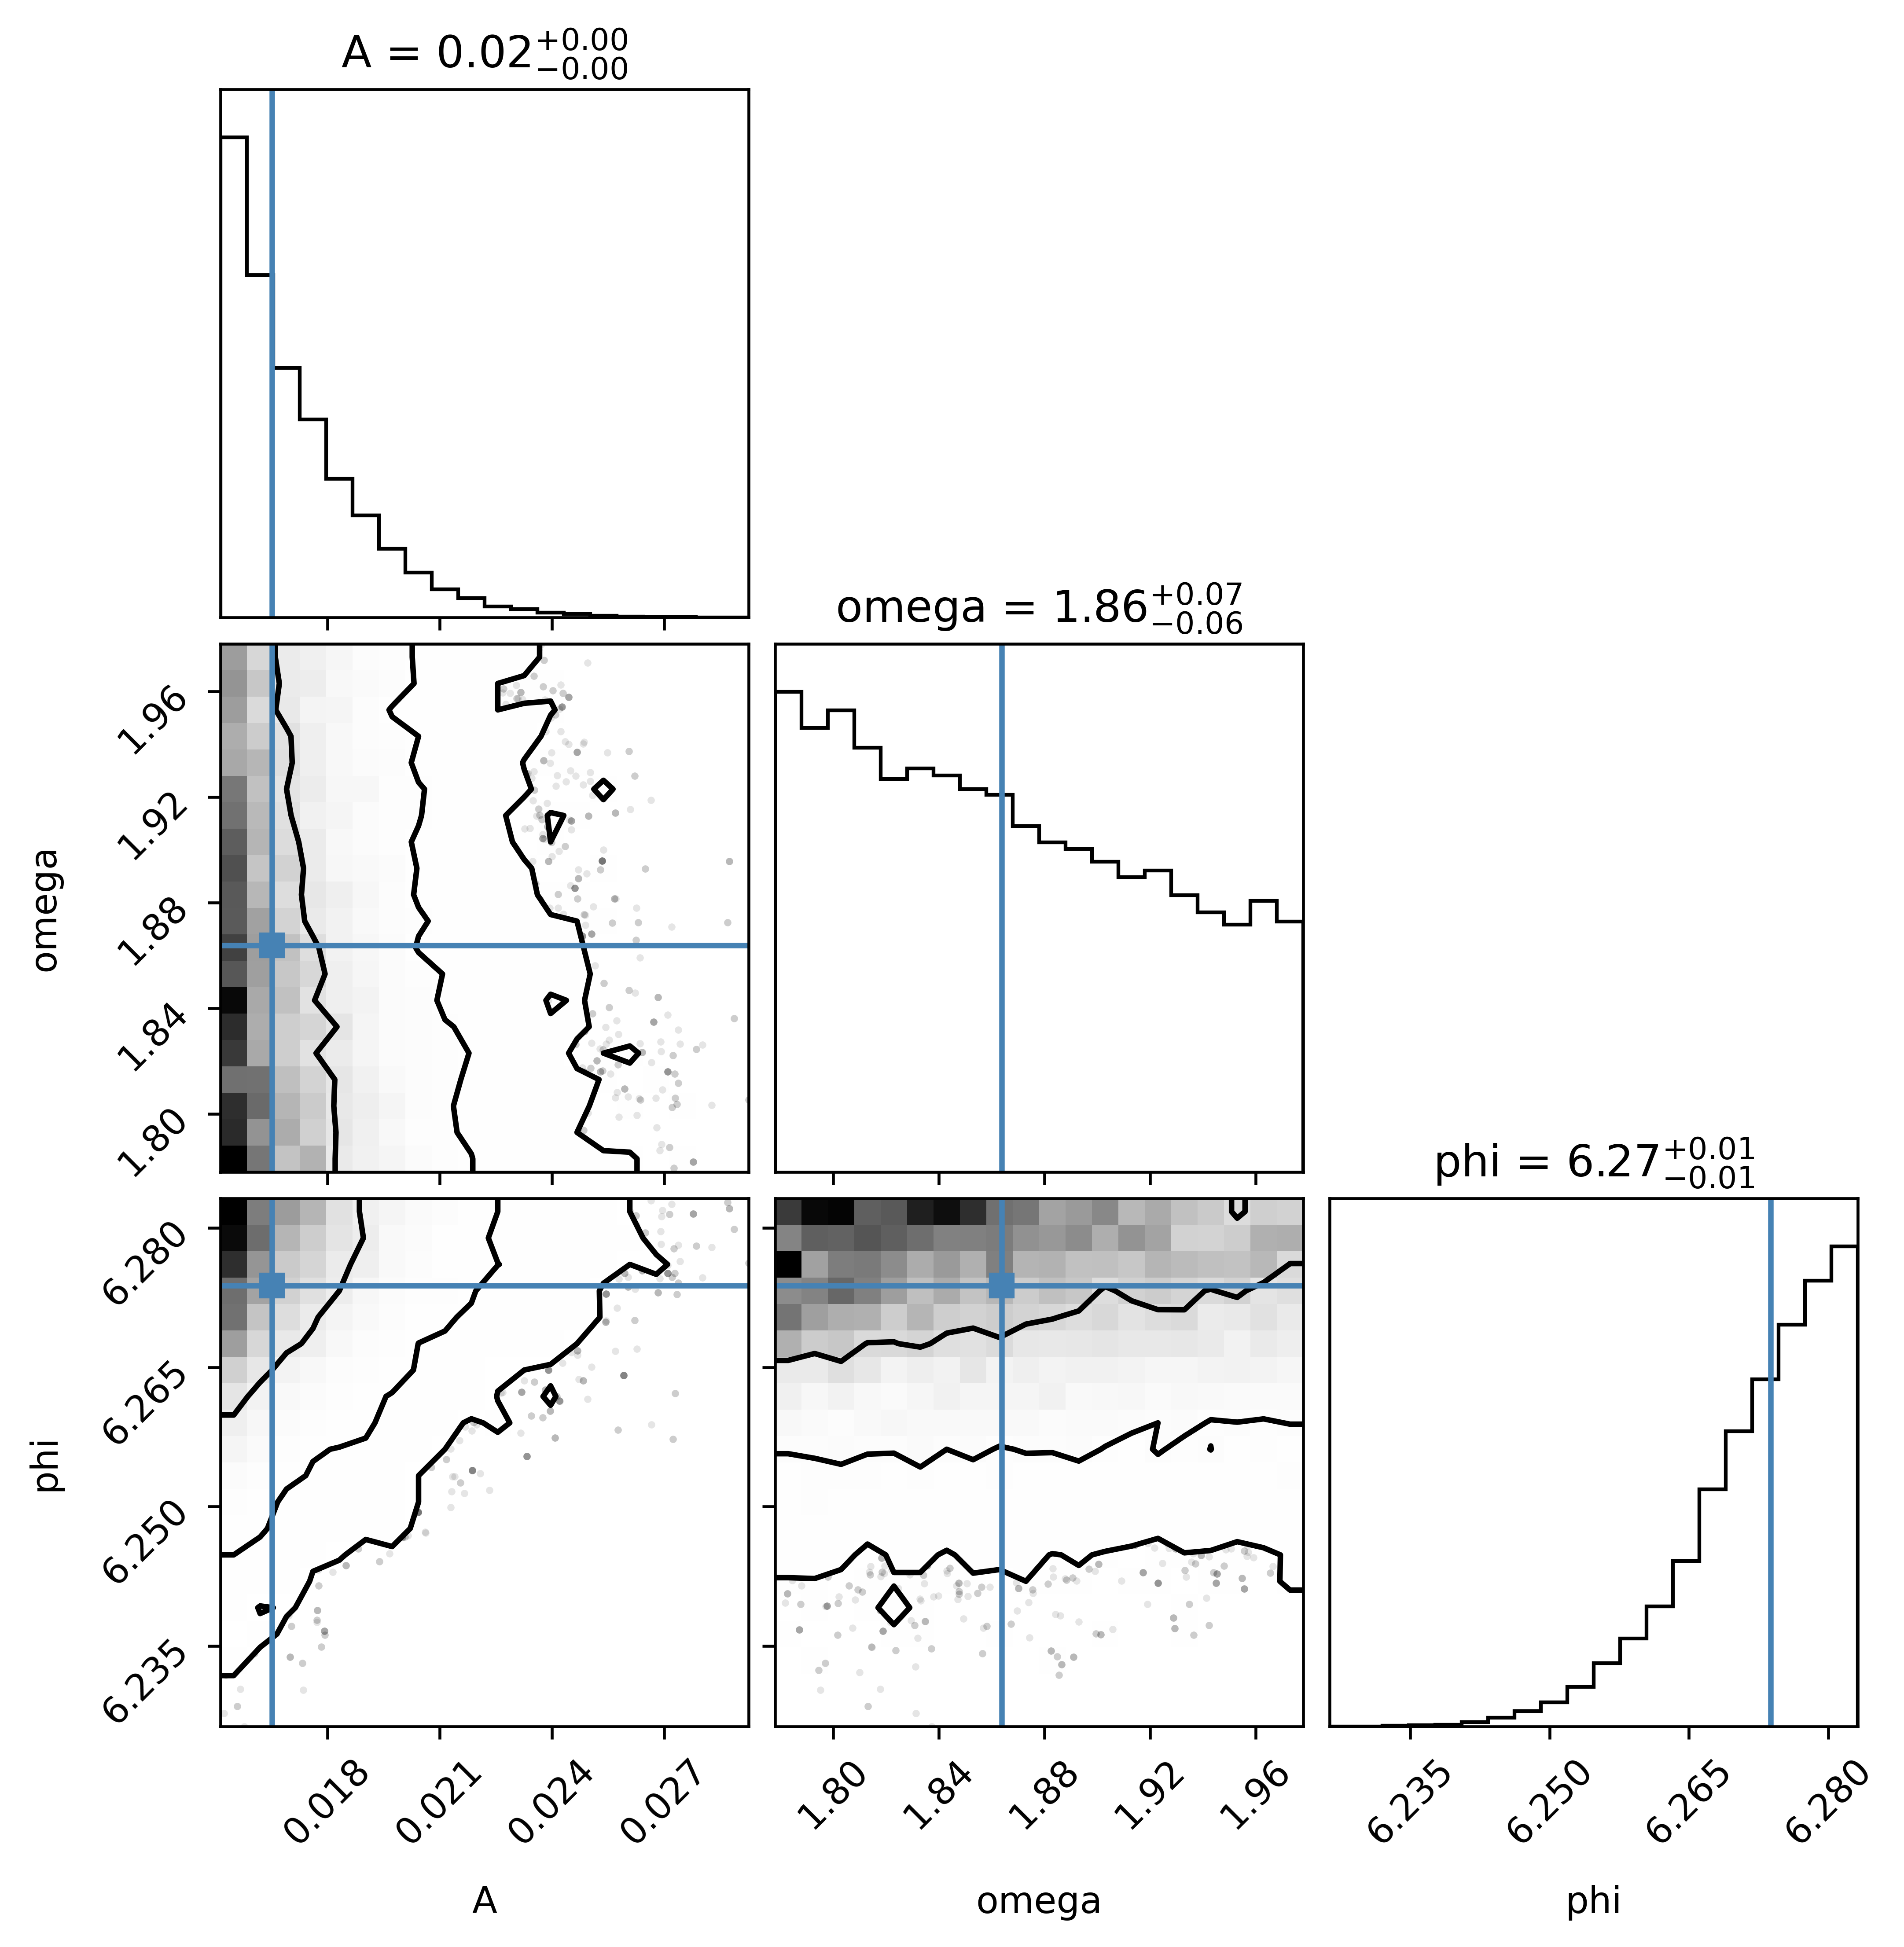

In [17]:
fig = corner.corner(
    emcee_trace, labels=labels, levels=[0.683, 0.955, 0.997], truths=median, show_titles=True) #0.5 quantile

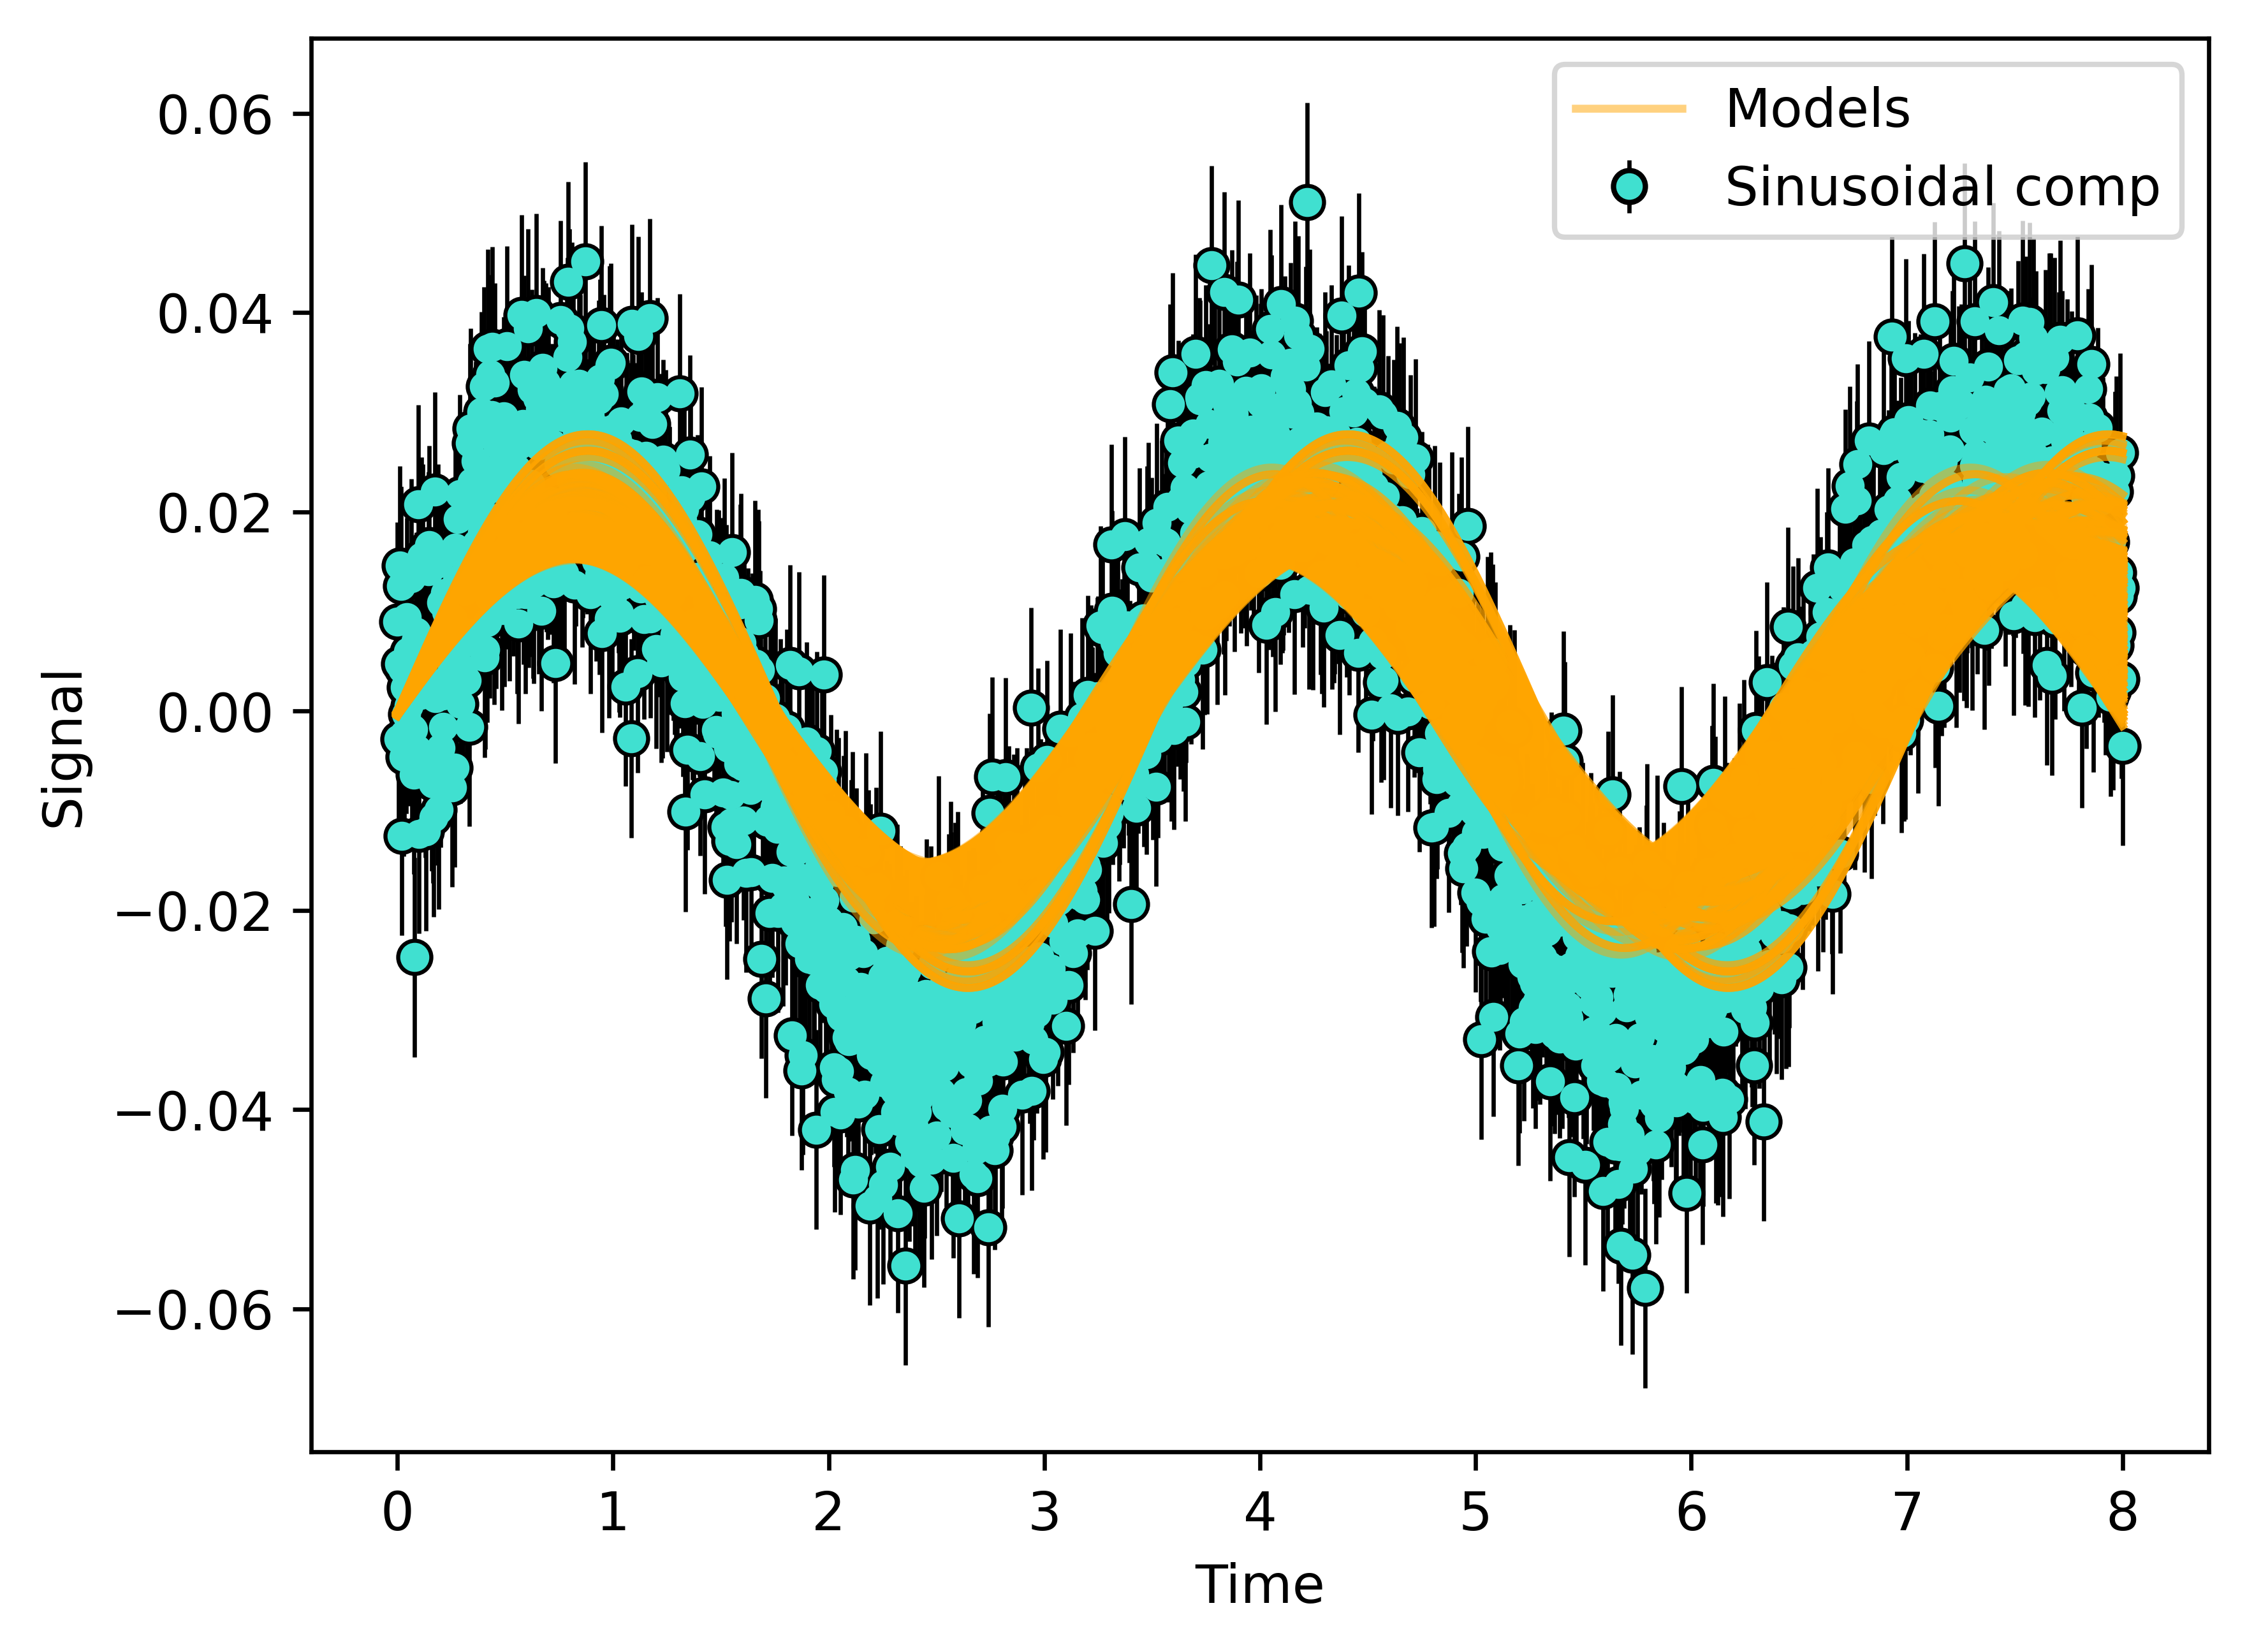

In [18]:
#plot 100 samples with the distrib of parameters found

a_i = emcee_trace[:,0]
omega_i = emcee_trace[:,1]
phi_i = emcee_trace[:,2]
y_predictions_0 = sinusoidal(xgrid, a_i[2000], omega_i[2000], phi_i[2000])

for i in range(1, 500):
    y_predictions = sinusoidal(xgrid, a_i[2000+i], omega_i[2000+i], phi_i[2000+i])
    plt.plot(xgrid, y_predictions, 'orange', alpha=0.5, zorder=2)
plt.plot(xgrid, y_predictions_0, 'orange', alpha=0.5, label='Models', zorder=2)
plt.errorbar(time,signal, yerr=sigma, fmt="o", ms=6, mec="black", ecolor='black', 
             elinewidth=0.8, mfc='turquoise', label='Sinusoidal comp', zorder=0)
plt.scatter(time,signal,color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=1)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()